In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [40]:
data = pd.read_csv('data/NYC_Motor_Vehicle_Collisions_Cleaned.csv')

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928322 entries, 0 to 1928321
Data columns (total 22 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   borough                        object 
 1   zip_code                       object 
 2   latitude                       float64
 3   longitude                      float64
 4   location                       object 
 5   on_street_name                 object 
 6   cross_street_name              object 
 7   off_street_name                object 
 8   number_of_persons_injured      float64
 9   number_of_persons_killed       float64
 10  number_of_pedestrians_injured  int64  
 11  number_of_pedestrians_killed   int64  
 12  number_of_cyclist_injured      int64  
 13  number_of_cyclist_killed       int64  
 14  number_of_motorist_injured     int64  
 15  number_of_motorist_killed      int64  
 16  contributing_factor_vehicle_1  object 
 17  contributing_factor_vehicle_2  object 
 18  co

In [42]:
data['crash_datetime'] = pd.to_datetime(data['crash_datetime'], errors='coerce')

In [43]:
# Extract more granular datetime features
data['month'] = data['crash_datetime'].dt.month
data['day_of_week'] = data['crash_datetime'].dt.day_name()
data['hour'] = data['crash_datetime'].dt.hour
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday'])

In [44]:
def classify_severity(row):
    if row['number_of_persons_killed'] > 0:
        return 'Fatal'
    elif row['number_of_persons_injured'] > 0:
        return 'Injury'
    else:
        return 'Property Damage Only'

data['severity'] = data.apply(classify_severity, axis=1)

In [45]:
data['total_casualties'] = data['number_of_persons_killed'] + data['number_of_persons_injured']

In [46]:
data['is_night'] = data['hour'].apply(lambda x: x < 6 or x > 20)

In [47]:
# Check current values
print(data['severity'].value_counts())

severity
Property Damage Only    1463278
Injury                   462229
Fatal                      2815
Name: count, dtype: int64


In [48]:
data['severity'] = data['severity'].apply(lambda x: 1 if x == 'Injury' or x == 'Fatal' else 0)

### Data Preparation

In [49]:
model_data = data.copy()

In [50]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928322 entries, 0 to 1928321
Data columns (total 29 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   borough                        object        
 1   zip_code                       object        
 2   latitude                       float64       
 3   longitude                      float64       
 4   location                       object        
 5   on_street_name                 object        
 6   cross_street_name              object        
 7   off_street_name                object        
 8   number_of_persons_injured      float64       
 9   number_of_persons_killed       float64       
 10  number_of_pedestrians_injured  int64         
 11  number_of_pedestrians_killed   int64         
 12  number_of_cyclist_injured      int64         
 13  number_of_cyclist_killed       int64         
 14  number_of_motorist_injured     int64         
 15  number_of_motor

In [51]:
# Drop columns that won't help the model
drop_cols = ['crash_datetime', 'month', 'hour', 'location', 'day_of_week', 'zip_code', 'collision_id', 'latitude', 'longitude']
model_data.drop(columns=drop_cols, inplace=True, errors='ignore')

In [14]:
leaky_cols = [
    'number_of_persons_injured',
    'number_of_persons_killed',
    'number_of_motorist_injured',
    'number_of_motorist_killed',
    'total_casualties',
]
model_data.drop(columns=leaky_cols, inplace=True, errors='ignore')

#### Correlation Analysis

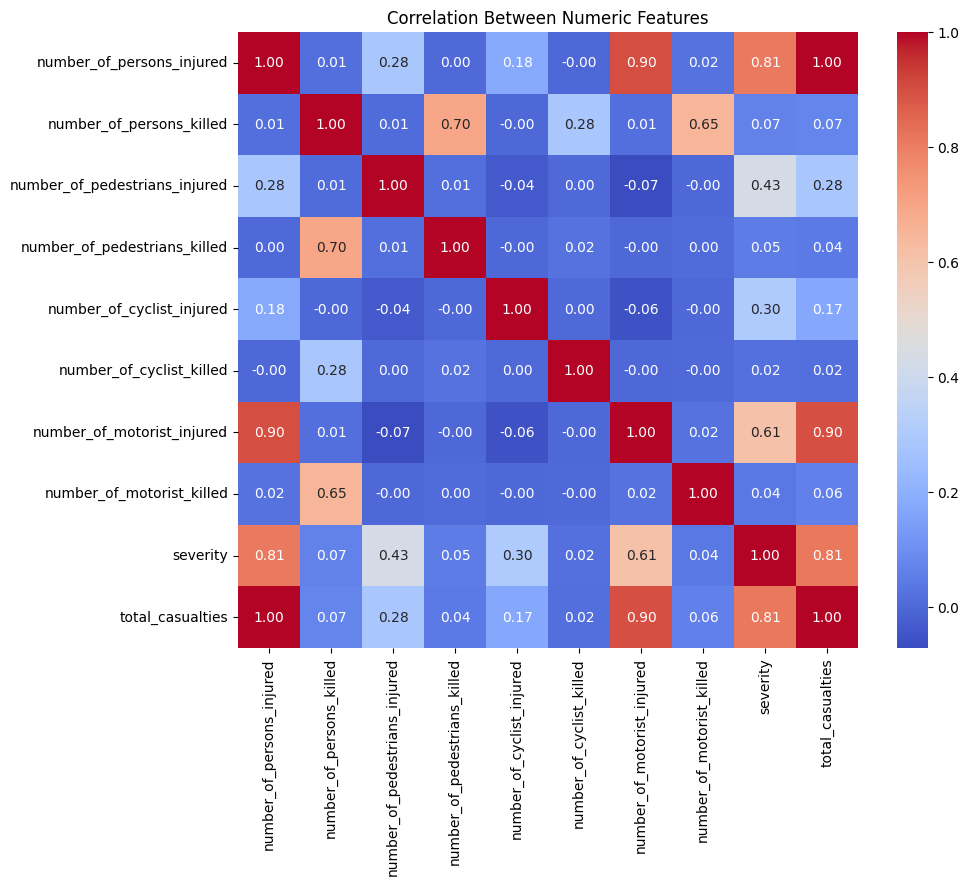

In [52]:
numeric_cols = model_data.select_dtypes(include='number')
plt.figure(figsize=(10,8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Numeric Features')
plt.show()

In [16]:
# Removing highly correlated features
corr_matrix = numeric_cols.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
print(f"Features to drop due to high correlation: {to_drop}")

Features to drop due to high correlation: []


In [17]:
model_data.drop(columns=to_drop, inplace=True)

### Encoding the Features

In [18]:
# Encode categorical features (if any)
categorical_cols = model_data.select_dtypes(include=['object', 'category']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    model_data[col] = le.fit_transform(model_data[col])
    label_encoders[col] = le

In [19]:
# drop NA values if any
model_data.dropna(inplace=True)

### Scaling and Splitting

In [20]:
X = model_data.drop('severity', axis=1)
y = model_data['severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
print(y.value_counts(normalize=True))

severity
0    0.758835
1    0.241165
Name: proportion, dtype: float64


In [22]:
# Scaling for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modeling

In [25]:
# Model Evaluation Function
def evaluate_model(model, X_train, X_test, scale=False):
    if scale:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{'='*30}\n{model.__class__.__name__} Evaluation")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

#### Logistic Regression

In [26]:
log_reg = LogisticRegression()
evaluate_model(log_reg, X_train, X_test, scale=True)


LogisticRegression Evaluation
              precision    recall  f1-score   support

           0       0.83      1.00      0.91    292656
           1       1.00      0.37      0.54     93009

    accuracy                           0.85    385665
   macro avg       0.92      0.68      0.72    385665
weighted avg       0.87      0.85      0.82    385665

ROC-AUC Score: 0.7399749579563756
Confusion Matrix:
[[292651      5]
 [ 58845  34164]]


#### Decision Tree

In [27]:
dt = DecisionTreeClassifier(random_state=42, max_depth=5, class_weight='balanced')
evaluate_model(dt, X_train, X_test)


DecisionTreeClassifier Evaluation
              precision    recall  f1-score   support

           0       0.83      0.98      0.90    292656
           1       0.89      0.38      0.53     93009

    accuracy                           0.84    385665
   macro avg       0.86      0.68      0.72    385665
weighted avg       0.85      0.84      0.81    385665

ROC-AUC Score: 0.754092465062284
Confusion Matrix:
[[288044   4612]
 [ 57452  35557]]


#### Random Forest

In [28]:
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight='balanced')
evaluate_model(rf, X_train, X_test)


RandomForestClassifier Evaluation
              precision    recall  f1-score   support

           0       0.86      0.90      0.88    292656
           1       0.63      0.53      0.58     93009

    accuracy                           0.81    385665
   macro avg       0.75      0.72      0.73    385665
weighted avg       0.80      0.81      0.81    385665

ROC-AUC Score: 0.8019220705762596
Confusion Matrix:
[[264305  28351]
 [ 43891  49118]]


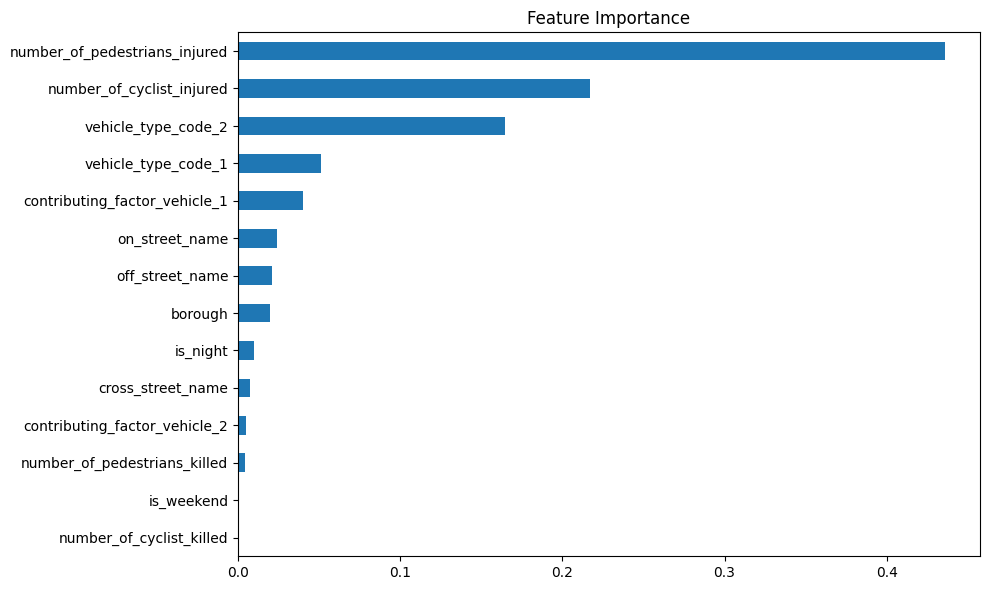

In [29]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 6), title='Feature Importance')
plt.tight_layout()
plt.show()

##### Hyperparameter Tuning

In [35]:
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

In [36]:
rf_base = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=20,  # Try just 20 combinations
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=101; total time= 2.5min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=101; total time= 2.5min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=114; total time= 2.7min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=114; total time= 2.8min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=114; total time= 2.8min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=120; total time= 2.9min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=120; total time= 2.9min
[CV] END class_weight=balanced, max_depth=None, min_sampl

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [10, 20, None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x32603ad50>},
                   random_state=42, scoring='f1', verbose=2)

In [37]:
print("Best Parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 274}


In [38]:
evaluate_model(best_rf, X_train, X_test)


RandomForestClassifier Evaluation
              precision    recall  f1-score   support

           0       0.86      0.91      0.89    292656
           1       0.66      0.54      0.60     93009

    accuracy                           0.82    385665
   macro avg       0.76      0.73      0.74    385665
weighted avg       0.81      0.82      0.82    385665

ROC-AUC Score: 0.8196583697606018
Confusion Matrix:
[[267099  25557]
 [ 42718  50291]]


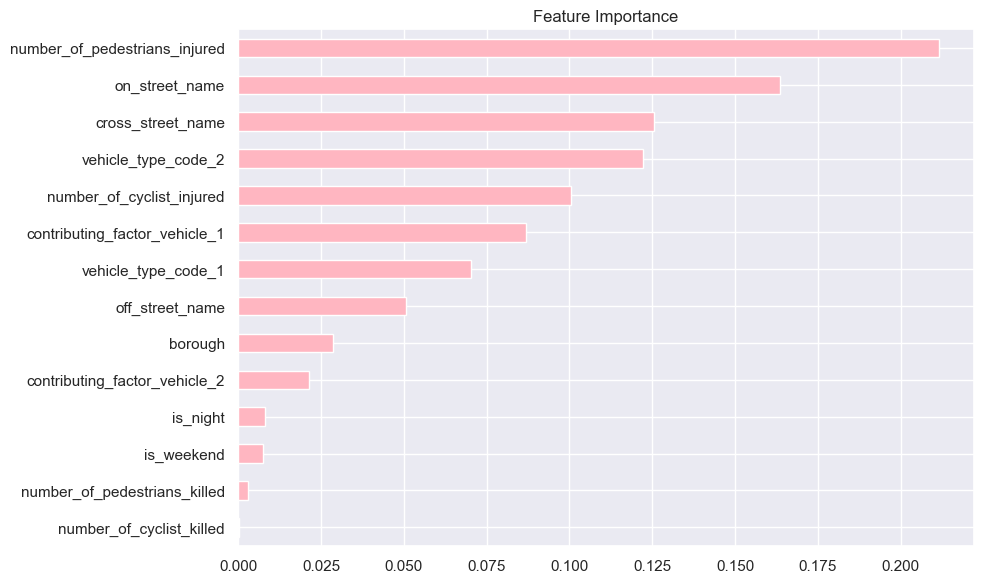

In [56]:
sns.set_theme(style='darkgrid')
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 6), title='Feature Importance', color='lightpink')
plt.tight_layout()
plt.show()